In [1]:
import torch
# Default CUDA device
cuda = torch.device('cuda')
# allocates a tensor on default GPU
a = torch.tensor([1., 2.], device=cuda)
# transfers a tensor from 'C'PU to 'G'PU
b = torch.tensor([1., 2.]).cuda()
# Same with .cuda()
b2 = torch.tensor([1., 2.]).to(device=cuda)

In [2]:
#  Returns a bool indicating if CUDA is currently available.
print(torch.cuda.is_available())
#  Returns the index of a currently selected device.
print(torch.cuda.current_device())
#  Returns the number of GPUs available.
print(torch.cuda.device_count())
#  Gets the name of a device.
print(torch.cuda.get_device_name(0))
#  Context-manager that changes the selected device.
#  device (torch.device or int) – device index to select. 
print(torch.cuda.device(0))

True
0
2
NVIDIA GeForce RTX 2080 Ti


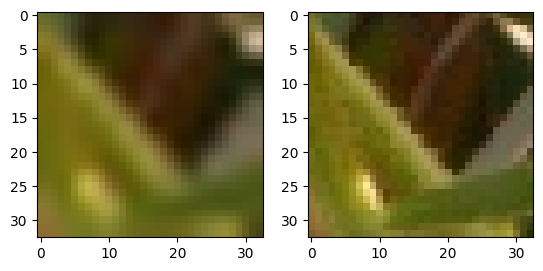

In [3]:
import torch
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2

from torch import nn
from torch.utils.data import Dataset, DataLoader
class SRCNNDataset(Dataset):
    def __init__(self, path, test, pad = 7, stride = 3, patch_size = (33, 19), sample = True):
        super(SRCNNDataset, self).__init__()
        
        self.stride = stride
        self.patch_size = patch_size
        self.pad = pad
        if test == True:
            self.img_paths_var = sorted(glob.glob('./dataset/Set5/LR/bicubic' + path + '/*.png'))
            self.img_paths_label = sorted(glob.glob('./dataset/Set5/HR/*.png'))
            var = []
            for img_path in self.img_paths_var:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img/255
                var.append(img)
            label = []
            for img_path in self.img_paths_label:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img/255
                label.append(img)
        else:
            self.img_paths_var = sorted(glob.glob('./dataset/T91/*.png'))
            self.img_paths_label = sorted(glob.glob('./dataset/T91/*.png'))
            var = []
            label = []
            for img_path in self.img_paths_var:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_height, img_width, _ = img.shape
                for x in range(0, img_width - patch_size[0] + 1, stride):
                    for y in range(0, img_height - patch_size[0] + 1, stride):
                        left = x
                        upper = y
                        right = x + patch_size[0]
                        lower = y + patch_size[0]
                        # Crop the image
                        cropped_img = img[upper : lower, left : right, : ]
                        label.append(cropped_img/255)
                        cropped_img_compressed = cv2.resize(cropped_img, dsize = (11, 11), interpolation = cv2.INTER_AREA)
                        cropped_img = cv2.resize(cropped_img_compressed, dsize = (patch_size[0], patch_size[0]), interpolation = cv2.INTER_CUBIC)
                        var.append(cropped_img/255)
        sample = {"image": var, "label": label}
        self.sample = sample
    def __len__(self):
        sample = self.sample
        return len(sample["image"])
    def __getitem__(self, index):
        sample = self.sample
        var = sample["image"][index]
        label = sample["label"][index]
        return var, label
        
dataset_train = SRCNNDataset(path = False, test = False)
dataloader_train = DataLoader(dataset = dataset_train, batch_size = 256, shuffle = True)
dataset_test = SRCNNDataset(path = '/X4', test = True)
dataloader_test = DataLoader(dataset = dataset_test, batch_size = 256, shuffle = True)
img1 = dataset_train.sample["image"][22091]
img2 = dataset_train.sample["label"][22091]
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

In [4]:
class SRCNN(nn.Module):
    def __init__(self, f1, f2, f3, n1, n2, n3):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= n3, out_channels= n1, kernel_size= f1, padding = 0)
        self.conv2 = nn.Conv2d(in_channels= n1, out_channels= n2, kernel_size= f2, padding = 0)
        self.conv3 = nn.Conv2d(in_channels= n2, out_channels= n3, kernel_size= f3, padding = 0)
        self.relu = nn.ReLU()
        
        
        torch.nn.init.xavier_normal_(self.conv1.weight, gain= 0.001)
        torch.nn.init.xavier_normal_(self.conv2.weight, gain= 0.001)
        torch.nn.init.xavier_normal_(self.conv3.weight, gain= 0.001)
        torch.nn.init.zeros_(self.conv1.bias)
        torch.nn.init.zeros_(self.conv2.bias)
        torch.nn.init.zeros_(self.conv3.bias)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    

In [26]:
n1, n2, n3 = 64, 32, 3
f1, f2, f3 = 9, 3, 5
srcnn = SRCNN(f1, f2, f3, n1, n2, n3)
srcnn.to('cuda')

#Validation
criterion = nn.MSELoss()
def convert_rgb_to_y(img):
    if type(img) == np.ndarray:
        return 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        return 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
    else:
        raise Exception('Unknown Type', type(img))
def test():
        srcnn.eval()
        psnr = 0
        for idx in range(5):
            inputs = dataset_test.sample["image"][idx]
            targets = dataset_test.sample["label"][idx]
            desired_target_width_size = targets.shape[0]
            desired_target_height_size = targets.shape[1]
            
            #Resize the inputs
            inputs = cv2.resize(inputs, dsize = (desired_target_height_size, desired_target_width_size), interpolation= cv2.INTER_CUBIC)
        
            #Apply the formation transforms
            inputs = torch.tensor(inputs).to('cuda')
            targets = torch.tensor(targets).to('cuda')
            
            #Crop the targets and change into the desired form
            cropped_targets = targets.unsqueeze(0)
            cropped_targets = cropped_targets.permute(0, 3, 1, 2)
            cropped_targets = cropped_targets[ : , : , 7 : -7, 7 : -7]

            #Change the input into the desired form
            targets = targets.unsqueeze(0)
            targets = targets.permute(0, 3, 1, 2)
            #targets = targets/255
            inputs = inputs.unsqueeze(0)
            inputs = inputs.permute(0, 3, 1, 2)
            #inputs = inputs/255

            outputs = srcnn(inputs.float())
            psnr_outputs = outputs * 255
            psnr_cropped_targets = cropped_targets * 255
            psnr_outputs = convert_rgb_to_y(psnr_outputs)
            psnr_cropped_targets = convert_rgb_to_y(psnr_cropped_targets)
            psnr_outputs = psnr_outputs / 255
            psnr_cropped_targets = psnr_cropped_targets / 255
            mse = (psnr_outputs - psnr_cropped_targets) ** 2
            mse = mse.detach().cpu().numpy()
            cropped = outputs.detach().cpu().numpy()
            mse_max = np.max(cropped)
            mse_value = np.sqrt(mse.mean())
            psnr_picture = 20 * np.log10(mse_max / mse_value)
            psnr += psnr_picture
        return psnr / 5

In [27]:
criterion = nn.MSELoss()
epochs = 100000
conv1 = srcnn.conv1
conv2 = srcnn.conv2
conv3 = srcnn.conv3
psnr_graph = []
num_epoch = []
number_of_backpropagation = 0
t = 0
srcnn.train()
for epoch in range(epochs):
    for batch_size , data in enumerate(dataloader_train, 0):
        inputs, labels = data[0].to('cuda'), data[1].to('cuda')
        optimizer = torch.optim.Adam([ {'params' : conv1.parameters(), 'lr' : 0.00001},
                                       {'params' : conv2.parameters(), 'lr' : 0.00001},
                                       {'params' : conv3.parameters(), 'lr' : 0.000001}])
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)
        inputs = inputs.permute(0, 3, 1, 2)
        labels = labels.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        output = srcnn(inputs)
        cropped_labels = labels[:, :, 7:-7, 7:-7]
        #cropped_labels = labels
        loss = criterion(output, cropped_labels)
        loss.backward()
        number_of_backpropagation = number_of_backpropagation + 1
        optimizer.step()
        if batch_size % 128 == 127:
            print(f'[{epoch}, {batch_size:5d}] loss : {loss : 3f}')
    psnr = test()
    print(epoch, loss, "PSNR : ", psnr) 
    psnr_graph.append(psnr)
    num_epoch.append(epoch)
    print(number_of_backpropagation)
    if psnr > 32:
        t = t + 1
print("successful : ", t)
plt.plot(num_epoch, psnr_graph)
plt.show()

[0,   127] loss :  0.270994
[0,   255] loss :  0.242832
[0,   383] loss :  0.159395
[0,   511] loss :  0.077532
[0,   639] loss :  0.028078
[0,   767] loss :  0.024596
[0,   895] loss :  0.026031
[0,  1023] loss :  0.024902
[0,  1151] loss :  0.025052
[0,  1279] loss :  0.026419
[0,  1407] loss :  0.025388
[0,  1535] loss :  0.026850
[0,  1663] loss :  0.023990
0 tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>) PSNR :  27.186399429802634
1790
[1,   127] loss :  0.024408
[1,   255] loss :  0.023413
[1,   383] loss :  0.022957
[1,   511] loss :  0.022002
[1,   639] loss :  0.022610
[1,   767] loss :  0.023423
[1,   895] loss :  0.022232
[1,  1023] loss :  0.018111
[1,  1151] loss :  0.017634
[1,  1279] loss :  0.014709
[1,  1407] loss :  0.012820
[1,  1535] loss :  0.011102
[1,  1663] loss :  0.009934
1 tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>) PSNR :  27.129787192032502
3580
[2,   127] loss :  0.009243
[2,   255] loss :  0.008763
[2,   383] loss :  0.008919


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

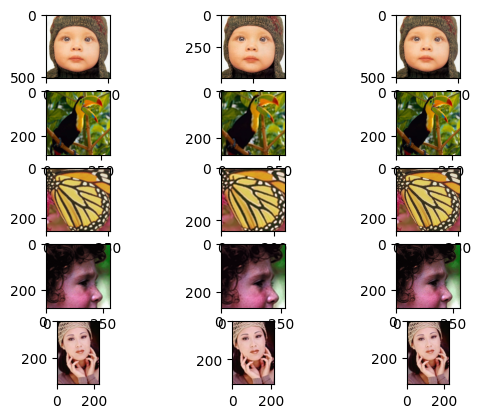

In [46]:
import matplotlib.pyplot as plt
def convert_rgb_to_y(img):
    if type(img) == np.ndarray:
        return 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        return 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
    else:
        raise Exception('Unknown Type', type(img))
srcnn.eval()
psnr = 0
psnr_picture = 0
i = 5
input_box, generated_box, output_box = [], [], []
for idx in range(i):
    with torch.no_grad():
        inputs = dataset_test.sample["image"][idx]
        targets = dataset_test.sample["label"][idx]
        desired_target_width_size = targets.shape[0]
        desired_target_height_size = targets.shape[1]

        #Resize the inputs
        inputs = cv2.resize(inputs, dsize = (desired_target_height_size, desired_target_width_size), interpolation= cv2.INTER_CUBIC)
        
        #Apply the formation transforms
        inputs = torch.tensor(inputs).to('cuda')
        targets = torch.tensor(targets).to('cuda')
            
        #Crop the targets and change into the desired form
        cropped_targets = targets.unsqueeze(0)
        cropped_targets = cropped_targets.permute(0, 3, 1, 2)
        cropped_targets = cropped_targets[ : , : , 7 : -7, 7 : -7]

        #Change the input into the desired form
        targets = targets.unsqueeze(0)
        targets = targets.permute(0, 3, 1, 2)
        inputs = inputs.unsqueeze(0)
        inputs = inputs.permute(0, 3, 1, 2)
        outputs = srcnn(inputs.float())
    outputs_final = outputs.permute(2, 3, 1, 0)
    targets_final = cropped_targets.permute(2, 3, 1, 0)
    targets_final = targets.permute(2, 3, 1, 0)
    output_size_height = outputs_final.shape[0]
    output_size_width = outputs_final.shape[1]
    target_size_height = targets_final.shape[0]
    target_size_width = targets_final.shape[1]
    outputs_final = outputs_final.view(output_size_height, output_size_width, 3)
    targets_final = targets_final.view(target_size_height, target_size_width, 3)
    outputs_final, targets_final = outputs_final.detach().cpu().numpy(), targets_final.detach().cpu().numpy()
    
    #inputs
    inputs = dataset_test.sample["image"][idx]
    desired_input_size = inputs.shape[1]
    desired_target_height_size = targets.shape[3]
    desired_target_width_size = targets.shape[2]
    inputs_final = cv2.resize(inputs, dsize = (desired_target_height_size, desired_target_width_size), interpolation= cv2.INTER_CUBIC)
    
    input_box.append(inputs_final)
    generated_box.append(outputs_final)
    output_box.append(targets_final)
    
    #plot
    plt.subplot(i, 3, 1 + 3 * idx)
    plt.imshow(input_box[idx])
    plt.subplot(i, 3, 2 + 3 * idx)
    plt.imshow(generated_box[idx])
    plt.subplot(i, 3, 3 + 3 * idx)
    plt.imshow(output_box[idx])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 498, 498])
tensor(3819, device='cuda:0')
34.09710466430682
0.021377624984389085
torch.Size([512, 512, 3, 1])
torch.Size([498, 498, 3, 1])
torch.Size([1, 3, 274, 274])
tensor(449, device='cuda:0')
34.03152119282245
0.024141088894839204
torch.Size([288, 288, 3, 1])
torch.Size([274, 274, 3, 1])
torch.Size([1, 3, 242, 242])
tensor(3502, device='cuda:0')
26.93360664067101
0.06232126087970862
torch.Size([256, 256, 3, 1])
torch.Size([242, 242, 3, 1])
torch.Size([1, 3, 266, 266])
tensor(94, device='cuda:0')
33.58327741432334
0.02264891320320834
torch.Size([280, 280, 3, 1])
torch.Size([266, 266, 3, 1])
torch.Size([1, 3, 330, 214])
tensor(681, device='cuda:0')
29.696441349590668
0.03724428346014285
torch.Size([344, 228, 3, 1])
torch.Size([330, 214, 3, 1])
psnr : 31.668390252342853


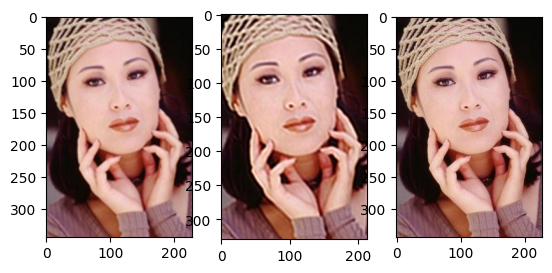

In [15]:
def convert_rgb_to_y(img):
    if type(img) == np.ndarray:
        return 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        return 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
    else:
        raise Exception('Unknown Type', type(img))
srcnn.eval()
psnr = 0
psnr_picture = 0
i = 5
for idx in range (i):
    with torch.no_grad():
        inputs = dataset_test.sample["image"][idx]
        targets = dataset_test.sample["label"][idx]
        desired_target_width_size = targets.shape[0]
        desired_target_height_size = targets.shape[1]
        #print(inputs.shape, targets.shape)
        #Resize the inputs
        inputs = cv2.resize(inputs, dsize = (desired_target_height_size, desired_target_width_size), interpolation= cv2.INTER_CUBIC)
        
        #Apply the formation transforms
        inputs = torch.tensor(inputs).to('cuda')
        targets = torch.tensor(targets).to('cuda')
            
        #Crop the targets and change into the desired form
        cropped_targets = targets.unsqueeze(0)
        cropped_targets = cropped_targets.permute(0, 3, 1, 2)
        cropped_targets = cropped_targets[ : , : , 7 : -7, 7 : -7]
        print(cropped_targets.shape)

        #Change the input into the desired form
        targets = targets.unsqueeze(0)
        targets = targets.permute(0, 3, 1, 2)
        #targets = targets/255
        inputs = inputs.unsqueeze(0)
        inputs = inputs.permute(0, 3, 1, 2)
        #inputs = inputs/255

        outputs = srcnn(inputs.float())
        psnr_outputs = outputs * 256
        psnr_cropped_targets = cropped_targets * 256
        psnr_outputs = convert_rgb_to_y(psnr_outputs)
        psnr_cropped_targets = convert_rgb_to_y(psnr_cropped_targets)
        psnr_outputs = psnr_outputs / 256
        psnr_cropped_targets = psnr_cropped_targets / 256
        mse = (psnr_outputs - psnr_cropped_targets) ** 2
        mse = mse.detach().cpu().numpy()
        cropped = outputs.detach().cpu().numpy()
        mse_max = np.max(cropped)
        mse_value = np.sqrt(mse.mean())
        psnr_picture = 20 * np.log10(mse_max / mse_value)
        print(sum(sum(sum(sum(outputs > 1)))))
        psnr += psnr_picture
        print(psnr_picture)
        print(mse_value)
    outputs_final = outputs.permute(2, 3, 1, 0)
    targets_final = cropped_targets.permute(2, 3, 1, 0)
    targets_final = targets.permute(2, 3, 1, 0)
    print(targets_final.shape)
    print(outputs_final.shape)
    output_size_height = outputs_final.shape[0]
    output_size_width = outputs_final.shape[1]
    target_size_height = targets_final.shape[0]
    target_size_width = targets_final.shape[1]
    outputs_final = outputs_final.view(output_size_height, output_size_width, 3)
    targets_final = targets_final.view(target_size_height, target_size_width, 3)
    outputs_final, targets_final = outputs_final.detach().cpu().numpy(), targets_final.detach().cpu().numpy()
    
    #inputs
    inputs = dataset_test.sample["image"][idx]
    desired_input_size = inputs.shape[1]
    desired_target_height_size = targets.shape[3]
    desired_target_width_size = targets.shape[2]
    inputs_final = cv2.resize(inputs, dsize = (desired_target_height_size, desired_target_width_size), interpolation= cv2.INTER_CUBIC)
    #inputs_final = cv2.cvtColor(inputs_final, cv2.COLOR_BGR2RGB)

    #plot
    plt.subplot(1, 3, 1)
    plt.imshow(inputs_final)
    plt.subplot(1, 3, 2)
    plt.imshow(outputs_final)
    plt.subplot(1, 3, 3)
    plt.imshow(targets_final)
#centercrop
print("psnr :", psnr/i)

In [29]:
import torch
from torchsummary import summary
srcnn_model = SRCNN(f1, f2, f3, n1, n2, n3)

# Move the model to the GPU
srcnn_model.to('cuda')

# Create a dummy input tensor and move it to the GPU
dummy_input = torch.randn((1, 3, 33, 33)).to('cuda')

# Print the model summary
summary(srcnn_model, input_size=(3, 33, 33), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 25, 25]          31,232
              ReLU-2          [-1, 128, 25, 25]               0
            Conv2d-3           [-1, 64, 23, 23]          73,792
              ReLU-4           [-1, 64, 23, 23]               0
            Conv2d-5            [-1, 3, 19, 19]           4,803
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.75
Params size (MB): 0.42
Estimated Total Size (MB): 2.18
----------------------------------------------------------------
